Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Epoch 1/10 - Train loss: 1.1194, Train acc: 0.6013 | Test loss: 0.8898, Test acc: 0.6660
Epoch 2/10 - Train loss: 0.6738, Train acc: 0.7451 | Test loss: 0.6436, Test acc: 0.7587
Epoch 3/10 - Train loss: 0.6002, Train acc: 0.7717 | Test loss: 0.5820, Test acc: 0.7813
Epoch 4/10 - Train loss: 0.5615, Train acc: 0.7896 | Test loss: 0.5853, Test acc: 0.7796
Epoch 5/10 - Train loss: 0.5317, Train acc: 0.8027 | Test loss: 0.5541, Test acc: 0.7893
Epoch 6/10 - Train loss: 0.5079, Train acc: 0.8118 | Test loss: 0.5912, Test acc: 0.7697
Epoch 7/10 - Train loss: 0.4922, Train acc: 0.8179 | Test loss: 0.5026, Test acc: 0.8155
Epoch 8/10 - Train loss: 0.4772, Train acc: 0.8246 | Test loss: 0.5058, Test acc: 0.8131
Epoch 9/10 - Train loss: 0.4637, Train acc: 0.8298 | Test loss: 0.4830, Test acc: 0.8256
Epoch 10/10 - Train loss: 0.4532, Train acc: 0.8345 | Test loss: 0.4821

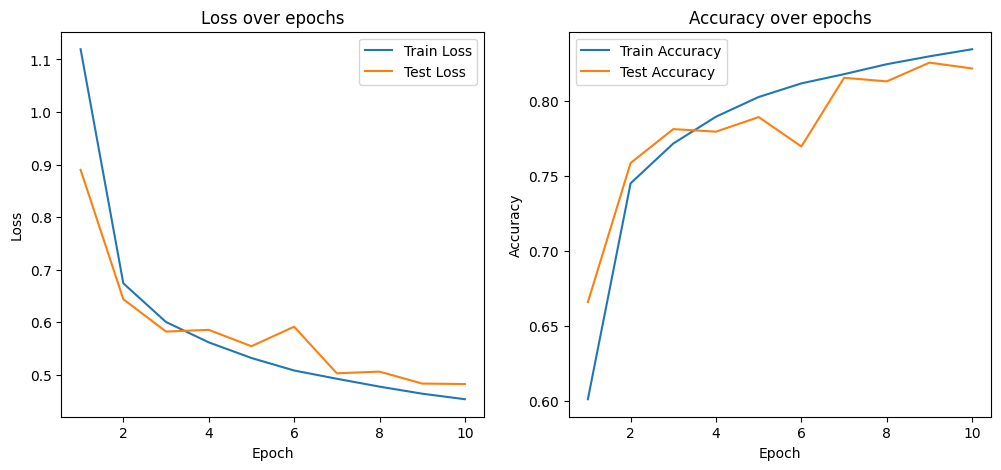

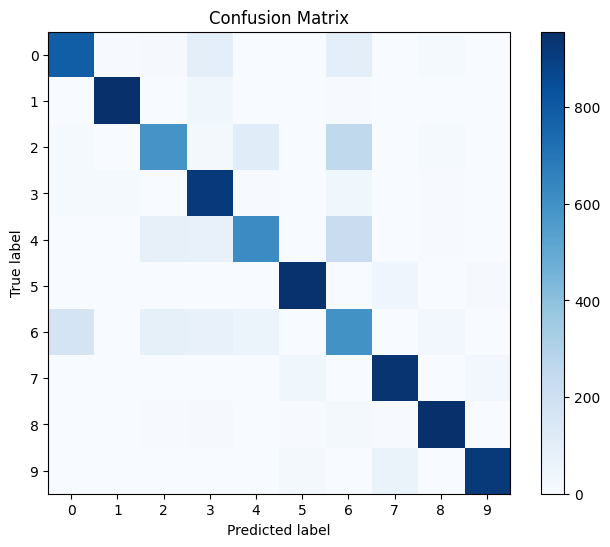

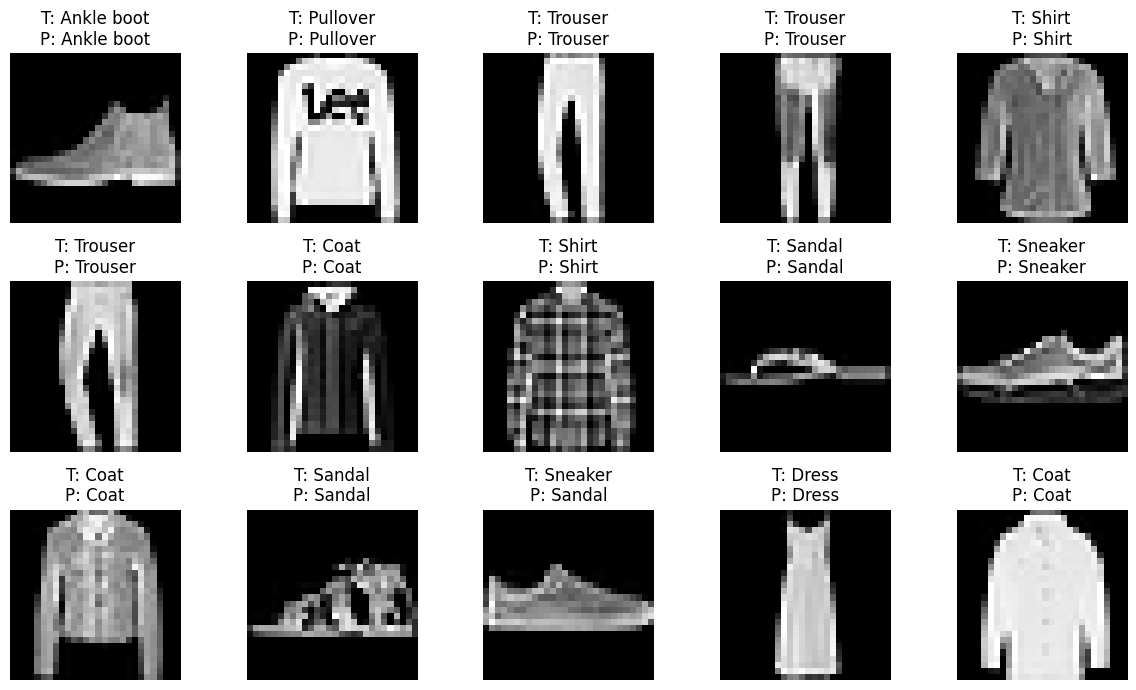

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
import gzip
import os
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --------------------------------
# Utils to load Fashion-MNIST
# --------------------------------
def download_mnist():
    base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }
    for key in files:
        if not os.path.exists(files[key]):
            print(f"Downloading {files[key]}...")
            request.urlretrieve(base_url + files[key], files[key])
        else:
            print(f"{files[key]} already exists.")

def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(16)  # skip magic number and dimensions
        buf = f.read()
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(-1, 28, 28).astype(np.float32) / 255.0
    return data

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(8)
        buf = f.read()
        labels = np.frombuffer(buf, dtype=np.uint8)
    return labels

download_mnist()

X_train = load_images("train-images-idx3-ubyte.gz")
y_train = load_labels("train-labels-idx1-ubyte.gz")

X_test = load_images("t10k-images-idx3-ubyte.gz")
y_test = load_labels("t10k-labels-idx1-ubyte.gz")

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# --------------------------------
# Train-test split (we already have official split)
# Let's shuffle training data for better training
# --------------------------------
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

# --------------------------------
# One-hot encoding function
# --------------------------------
def one_hot(y, num_classes=10):
    onehot = np.zeros((y.size, num_classes))
    onehot[np.arange(y.size), y] = 1
    return onehot

y_train_onehot = one_hot(y_train)
y_test_onehot = one_hot(y_test)

# --------------------------------
# LeNet Components Implementation
# --------------------------------
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # input_data: (N, C, H, W)
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad,pad), (pad,pad)], 'constant')
    cols = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            cols[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    cols = cols.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w, -1)
    return cols

def col2im(cols, input_shape, filter_h, filter_w, stride=1, pad=0):
    # input_shape: (N, C, H, W)
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    cols = cols.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)

    img = np.zeros((N, C, H + 2*pad + stride -1, W + 2*pad + stride -1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += cols[:,:,y,x,:,:]

    return img[:, :, pad:H + pad, pad:W + pad]

# --------------------------------
# Layers
# --------------------------------

class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        # Xavier Initialization
        scale = np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * scale
        self.b = np.zeros(out_channels)

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape

        self.col = im2col(x, self.kernel_size, self.kernel_size, self.stride, self.padding)
        W_col = self.W.reshape(self.out_channels, -1)

        out = self.col @ W_col.T + self.b
        out_h = (H + 2*self.padding - self.kernel_size)//self.stride + 1
        out_w = (W + 2*self.padding - self.kernel_size)//self.stride + 1
        out = out.reshape(N, out_h, out_w, self.out_channels).transpose(0,3,1,2)
        return out

    def backward(self, dout, learning_rate):
        N, C, H, W = self.x.shape
        dout_reshaped = dout.transpose(0,2,3,1).reshape(-1, self.out_channels)

        dW = dout_reshaped.T @ self.col
        dW = dW.reshape(self.W.shape)
        db = dout_reshaped.sum(axis=0)

        W_col = self.W.reshape(self.out_channels, -1)
        dcol = dout_reshaped @ W_col
        dx = col2im(dcol, self.x.shape, self.kernel_size, self.kernel_size, self.stride, self.padding)

        # Update weights
        self.W -= learning_rate * dW
        self.b -= learning_rate * db

        return dx

class AvgPool:
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape

        out_h = (H - self.kernel_size)//self.stride + 1
        out_w = (W - self.kernel_size)//self.stride + 1

        self.col = im2col(x, self.kernel_size, self.kernel_size, self.stride, 0)
        self.col = self.col.reshape(-1, self.kernel_size*self.kernel_size)
        out = np.mean(self.col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
        return out

    def backward(self, dout):
        N, C, out_h, out_w = dout.shape

        dout_flat = dout.transpose(0,2,3,1).flatten()

        dcol = np.zeros((dout_flat.size, self.kernel_size*self.kernel_size))
        dcol[:] = dout_flat[:, None] / (self.kernel_size * self.kernel_size)

        dcol = dcol.reshape(N*out_h*out_w*C, self.kernel_size*self.kernel_size)

        dx = col2im(dcol, self.x.shape, self.kernel_size, self.kernel_size, self.stride, 0)
        return dx

class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, dout):
        return dout.reshape(self.orig_shape)

class FullyConnected:
    def __init__(self, input_dim, output_dim):
        scale = np.sqrt(2.0 / input_dim)
        self.W = np.random.randn(input_dim, output_dim) * scale
        self.b = np.zeros(output_dim)

    def forward(self, x):
        self.x = x
        out = x @ self.W + self.b
        return out

    def backward(self, dout, learning_rate):
        dW = self.x.T @ dout
        db = np.sum(dout, axis=0)
        dx = dout @ self.W.T

        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dx

class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask

class SoftmaxCrossEntropyLoss:
    def forward(self, logits, labels):
        # logits: (N, num_classes)
        # labels: one-hot (N, num_classes)
        self.labels = labels
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        # cross entropy loss
        loss = -np.sum(labels * np.log(self.probs + 1e-10)) / logits.shape[0]
        return loss

    def backward(self):
        # Gradient of loss w.r.t logits
        return (self.probs - self.labels) / self.labels.shape[0]

# --------------------------------
# LeNet Model
# --------------------------------
class LeNet:
    def __init__(self):
        # For Fashion-MNIST 1 channel input
        self.conv1 = ConvLayer(1, 6, 5, stride=1, padding=0) # (28-5+1)=24
        self.relu1 = ReLU()
        self.pool1 = AvgPool(2, 2) # 24->12

        self.conv2 = ConvLayer(6, 16, 5, stride=1, padding=0) # (12-5+1)=8
        self.relu2 = ReLU()
        self.pool2 = AvgPool(2, 2) # 8->4

        self.flatten = Flatten()

        self.fc1 = FullyConnected(16*4*4, 120)
        self.relu3 = ReLU()

        self.fc2 = FullyConnected(120, 84)
        self.relu4 = ReLU()

        self.fc3 = FullyConnected(84, 10)

        self.loss_fn = SoftmaxCrossEntropyLoss()

    def forward(self, x, y=None):
        out = self.conv1.forward(x)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)

        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)

        out = self.flatten.forward(out)

        out = self.fc1.forward(out)
        out = self.relu3.forward(out)

        out = self.fc2.forward(out)
        out = self.relu4.forward(out)

        logits = self.fc3.forward(out)

        if y is not None:
            loss = self.loss_fn.forward(logits, y)
            return logits, loss
        else:
            return logits

    def backward(self, learning_rate):
        dout = self.loss_fn.backward()

        dout = self.fc3.backward(dout, learning_rate)
        dout = self.relu4.backward(dout)
        dout = self.fc2.backward(dout, learning_rate)
        dout = self.relu3.backward(dout)
        dout = self.fc1.backward(dout, learning_rate)

        dout = self.flatten.backward(dout)

        dout = self.pool2.backward(dout)
        dout = self.relu2.backward(dout)
        dout = self.conv2.backward(dout, learning_rate)

        dout = self.pool1.backward(dout)
        dout = self.relu1.backward(dout)
        dout = self.conv1.backward(dout, learning_rate)

# --------------------------------
# Training and evaluation functions
# --------------------------------
def accuracy(preds, labels):
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    return np.mean(pred_labels == true_labels)

def metrics(preds, labels):
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    acc = np.mean(pred_labels == true_labels)
    return acc, precision, recall, f1

def evaluate(model, X, y_onehot, batch_size=64):
    total_loss = 0
    total_acc = 0
    preds_list = []
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = y_onehot[i:i+batch_size]
        x_batch = x_batch.reshape(-1, 1, 28, 28)
        logits, loss = model.forward(x_batch, y_batch)
        total_loss += loss * len(x_batch)
        total_acc += accuracy(logits, y_batch) * len(x_batch)
        preds_list.append(logits)
    avg_loss = total_loss / len(X)
    avg_acc = total_acc / len(X)
    preds_all = np.vstack(preds_list)
    return avg_loss, avg_acc, preds_all

# --------------------------------
# Training loop
# --------------------------------
np.random.seed(42)
model = LeNet()
learning_rate = 0.01
epochs = 10
batch_size = 128

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    perm = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train_onehot[perm]

    epoch_loss = 0
    epoch_acc = 0

    for i in range(0, len(X_train), batch_size):
        x_batch = X_train_shuffled[i:i+batch_size].reshape(-1, 1, 28, 28)
        y_batch = y_train_shuffled[i:i+batch_size]

        logits, loss = model.forward(x_batch, y_batch)
        epoch_loss += loss * len(x_batch)
        epoch_acc += accuracy(logits, y_batch) * len(x_batch)
        model.backward(learning_rate)

    train_loss = epoch_loss / len(X_train)
    train_acc = epoch_acc / len(X_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc, _ = evaluate(model, X_test, y_test_onehot, batch_size)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# --------------------------------
# Final evaluation metrics on test set
# --------------------------------
_, _, test_preds = evaluate(model, X_test, y_test_onehot)
acc, precision, recall, f1 = metrics(test_preds, y_test_onehot)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# --------------------------------
# Plotting loss and accuracy
# --------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.show()

# --------------------------------
# Confusion Matrix
# --------------------------------
pred_labels = np.argmax(test_preds, axis=1)
true_labels = y_test
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# --------------------------------
# Show some test images with predictions
# --------------------------------
fig, axes = plt.subplots(3, 5, figsize=(12,7))
axes = axes.flatten()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(15):
    img = X_test[i]
    true_label = class_names[true_labels[i]]
    pred_label = class_names[pred_labels[i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"T: {true_label}\nP: {pred_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


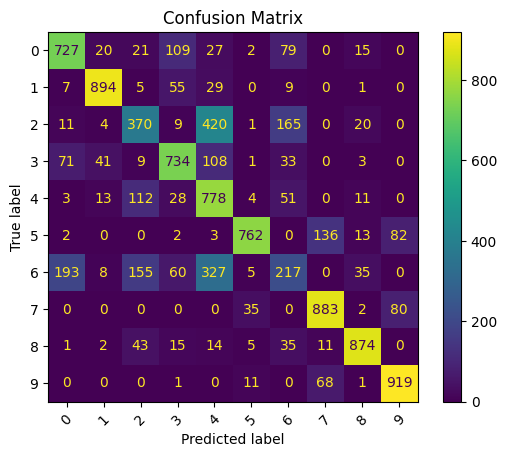

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

true_labels = y_test
pred_labels = np.argmax(test_preds, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.
Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Epoch 1/20 - Train loss: 2.3071, Train acc: 0.1023 | Test loss: 2.2597, Test acc: 0.1133
Epoch 2/20 - Train loss: 2.2368, Train acc: 0.1356 | Test loss: 2.2113, Test acc: 0.1649
Epoch 3/20 - Train loss: 2.1806, Train acc: 0.1974 | Test loss: 2.1432, Test acc: 0.2409
Epoch 4/20 - Train loss: 2.0911, Train acc: 0.2891 | Test loss: 2.0293, Test acc: 0.3212
Epoch 5/20 - Train loss: 1.9453, Train acc: 0.3441 | Test loss: 1.8534, Test acc: 0.3567
Epoch 6/20 - Train loss: 1.7504, Train acc: 0.4127 | Test loss: 1.6518, Test acc: 0.4549
Epoch 7/20 - Train loss: 1.5542, Train acc: 0.5130 | Test loss: 1.4685, Test acc: 0.5420
Epoch 8/20 - Train loss: 1.3852, Train acc: 0.5715 | Test loss: 1.3184, Test ac

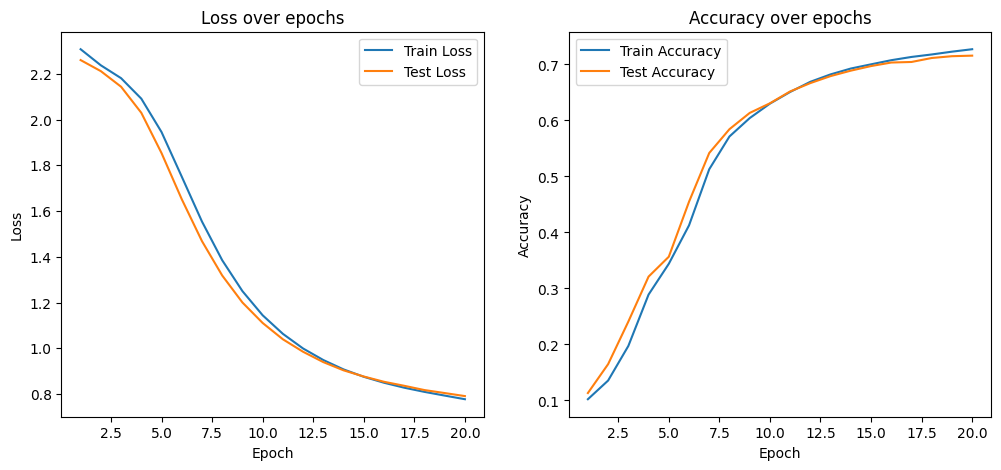

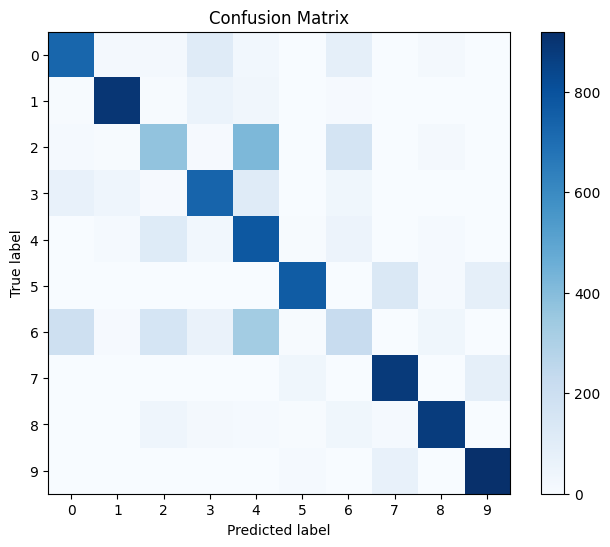

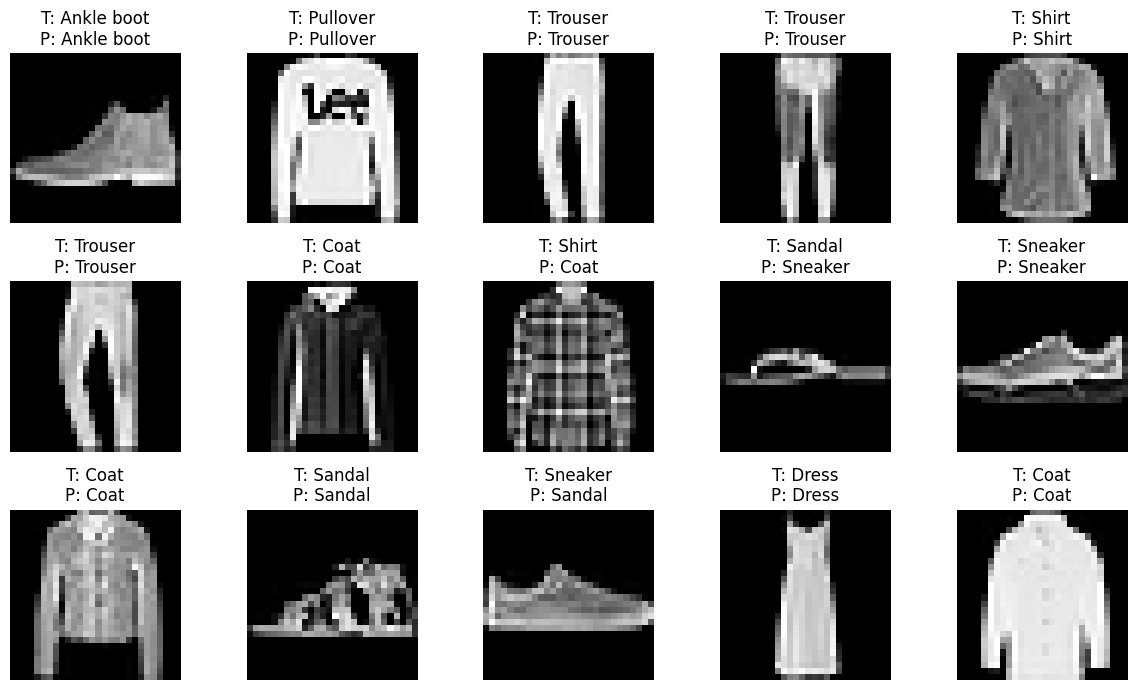

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
import gzip
import os
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --------------------------------
# Utils to load Fashion-MNIST
# --------------------------------
def download_mnist():
    base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }
    for key in files:
        if not os.path.exists(files[key]):
            print(f"Downloading {files[key]}...")
            request.urlretrieve(base_url + files[key], files[key])
        else:
            print(f"{files[key]} already exists.")

def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(16)  # skip magic number and dimensions
        buf = f.read()
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(-1, 28, 28).astype(np.float32) / 255.0
    return data

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(8)
        buf = f.read()
        labels = np.frombuffer(buf, dtype=np.uint8)
    return labels

download_mnist()

X_train = load_images("train-images-idx3-ubyte.gz")
y_train = load_labels("train-labels-idx1-ubyte.gz")

X_test = load_images("t10k-images-idx3-ubyte.gz")
y_test = load_labels("t10k-labels-idx1-ubyte.gz")

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# --------------------------------
# Train-test split (we already have official split)
# Let's shuffle training data for better training
# --------------------------------
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

# --------------------------------
# One-hot encoding function
# --------------------------------
def one_hot(y, num_classes=10):
    onehot = np.zeros((y.size, num_classes))
    onehot[np.arange(y.size), y] = 1
    return onehot

y_train_onehot = one_hot(y_train)
y_test_onehot = one_hot(y_test)

# --------------------------------
# LeNet Components Implementation
# --------------------------------
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # input_data: (N, C, H, W)
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad,pad), (pad,pad)], 'constant')
    cols = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            cols[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    cols = cols.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w, -1)
    return cols

def col2im(cols, input_shape, filter_h, filter_w, stride=1, pad=0):
    # input_shape: (N, C, H, W)
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    cols = cols.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)

    img = np.zeros((N, C, H + 2*pad + stride -1, W + 2*pad + stride -1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += cols[:,:,y,x,:,:]

    return img[:, :, pad:H + pad, pad:W + pad]

# --------------------------------
# Layers
# --------------------------------

class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        # Xavier Initialization
        scale = np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * scale
        self.b = np.zeros(out_channels)

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape

        self.col = im2col(x, self.kernel_size, self.kernel_size, self.stride, self.padding)
        W_col = self.W.reshape(self.out_channels, -1)

        out = self.col @ W_col.T + self.b
        out_h = (H + 2*self.padding - self.kernel_size)//self.stride + 1
        out_w = (W + 2*self.padding - self.kernel_size)//self.stride + 1
        out = out.reshape(N, out_h, out_w, self.out_channels).transpose(0,3,1,2)
        return out

    def backward(self, dout, learning_rate):
        N, C, H, W = self.x.shape
        dout_reshaped = dout.transpose(0,2,3,1).reshape(-1, self.out_channels)

        dW = dout_reshaped.T @ self.col
        dW = dW.reshape(self.W.shape)
        db = dout_reshaped.sum(axis=0)

        W_col = self.W.reshape(self.out_channels, -1)
        dcol = dout_reshaped @ W_col
        dx = col2im(dcol, self.x.shape, self.kernel_size, self.kernel_size, self.stride, self.padding)

        # Update weights
        self.W -= learning_rate * dW
        self.b -= learning_rate * db

        return dx

class AvgPool:
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape

        out_h = (H - self.kernel_size)//self.stride + 1
        out_w = (W - self.kernel_size)//self.stride + 1

        self.col = im2col(x, self.kernel_size, self.kernel_size, self.stride, 0)
        self.col = self.col.reshape(-1, self.kernel_size*self.kernel_size)
        out = np.mean(self.col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
        return out

    def backward(self, dout):
        N, C, out_h, out_w = dout.shape

        dout_flat = dout.transpose(0,2,3,1).flatten()

        dcol = np.zeros((dout_flat.size, self.kernel_size*self.kernel_size))
        dcol[:] = dout_flat[:, None] / (self.kernel_size * self.kernel_size)

        dcol = dcol.reshape(N*out_h*out_w*C, self.kernel_size*self.kernel_size)

        dx = col2im(dcol, self.x.shape, self.kernel_size, self.kernel_size, self.stride, 0)
        return dx

class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, dout):
        return dout.reshape(self.orig_shape)

class FullyConnected:
    def __init__(self, input_dim, output_dim):
        scale = np.sqrt(2.0 / input_dim)
        self.W = np.random.randn(input_dim, output_dim) * scale
        self.b = np.zeros(output_dim)

    def forward(self, x):
        self.x = x
        out = x @ self.W + self.b
        return out

    def backward(self, dout, learning_rate):
        dW = self.x.T @ dout
        db = np.sum(dout, axis=0)
        dx = dout @ self.W.T

        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dx

class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask

class SoftmaxCrossEntropyLoss:
    def forward(self, logits, labels):
        # logits: (N, num_classes)
        # labels: one-hot (N, num_classes)
        self.labels = labels
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        # cross entropy loss
        loss = -np.sum(labels * np.log(self.probs + 1e-10)) / logits.shape[0]
        return loss

    def backward(self):
        # Gradient of loss w.r.t logits
        return (self.probs - self.labels) / self.labels.shape[0]

# --------------------------------
# LeNet Model
# --------------------------------
class LeNet:
    def __init__(self):
        # For Fashion-MNIST 1 channel input
        self.conv1 = ConvLayer(1, 6, 5, stride=1, padding=0) # (28-5+1)=24
        self.relu1 = ReLU()
        self.pool1 = AvgPool(2, 2) # 24->12

        self.conv2 = ConvLayer(6, 16, 5, stride=1, padding=0) # (12-5+1)=8
        self.relu2 = ReLU()
        self.pool2 = AvgPool(2, 2) # 8->4

        self.flatten = Flatten()

        self.fc1 = FullyConnected(16*4*4, 120)
        self.relu3 = ReLU()

        self.fc2 = FullyConnected(120, 84)
        self.relu4 = ReLU()

        self.fc3 = FullyConnected(84, 10)

        self.loss_fn = SoftmaxCrossEntropyLoss()

    def forward(self, x, y=None):
        out = self.conv1.forward(x)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)

        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)

        out = self.flatten.forward(out)

        out = self.fc1.forward(out)
        out = self.relu3.forward(out)

        out = self.fc2.forward(out)
        out = self.relu4.forward(out)

        logits = self.fc3.forward(out)

        if y is not None:
            loss = self.loss_fn.forward(logits, y)
            return logits, loss
        else:
            return logits

    def backward(self, learning_rate):
        dout = self.loss_fn.backward()

        dout = self.fc3.backward(dout, learning_rate)
        dout = self.relu4.backward(dout)
        dout = self.fc2.backward(dout, learning_rate)
        dout = self.relu3.backward(dout)
        dout = self.fc1.backward(dout, learning_rate)

        dout = self.flatten.backward(dout)

        dout = self.pool2.backward(dout)
        dout = self.relu2.backward(dout)
        dout = self.conv2.backward(dout, learning_rate)

        dout = self.pool1.backward(dout)
        dout = self.relu1.backward(dout)
        dout = self.conv1.backward(dout, learning_rate)

# --------------------------------
# Training and evaluation functions
# --------------------------------
def accuracy(preds, labels):
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    return np.mean(pred_labels == true_labels)

def metrics(preds, labels):
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    acc = np.mean(pred_labels == true_labels)
    return acc, precision, recall, f1

def evaluate(model, X, y_onehot, batch_size=64):
    total_loss = 0
    total_acc = 0
    preds_list = []
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = y_onehot[i:i+batch_size]
        x_batch = x_batch.reshape(-1, 1, 28, 28)
        logits, loss = model.forward(x_batch, y_batch)
        total_loss += loss * len(x_batch)
        total_acc += accuracy(logits, y_batch) * len(x_batch)
        preds_list.append(logits)
    avg_loss = total_loss / len(X)
    avg_acc = total_acc / len(X)
    preds_all = np.vstack(preds_list)
    return avg_loss, avg_acc, preds_all

# --------------------------------
# Training loop
# --------------------------------
np.random.seed(42)
model = LeNet()
learning_rate = 0.0005
epochs = 20
batch_size = 256

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    perm = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train_onehot[perm]

    epoch_loss = 0
    epoch_acc = 0

    for i in range(0, len(X_train), batch_size):
        x_batch = X_train_shuffled[i:i+batch_size].reshape(-1, 1, 28, 28)
        y_batch = y_train_shuffled[i:i+batch_size]

        logits, loss = model.forward(x_batch, y_batch)
        epoch_loss += loss * len(x_batch)
        epoch_acc += accuracy(logits, y_batch) * len(x_batch)
        model.backward(learning_rate)

    train_loss = epoch_loss / len(X_train)
    train_acc = epoch_acc / len(X_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc, _ = evaluate(model, X_test, y_test_onehot, batch_size)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# --------------------------------
# Final evaluation metrics on test set
# --------------------------------
_, _, test_preds = evaluate(model, X_test, y_test_onehot)
acc, precision, recall, f1 = metrics(test_preds, y_test_onehot)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# --------------------------------
# Plotting loss and accuracy
# --------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.show()

# --------------------------------
# Confusion Matrix
# --------------------------------
pred_labels = np.argmax(test_preds, axis=1)
true_labels = y_test
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# --------------------------------
# Show some test images with predictions
# --------------------------------
fig, axes = plt.subplots(3, 5, figsize=(12,7))
axes = axes.flatten()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(15):
    img = X_test[i]
    true_label = class_names[true_labels[i]]
    pred_label = class_names[pred_labels[i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"T: {true_label}\nP: {pred_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


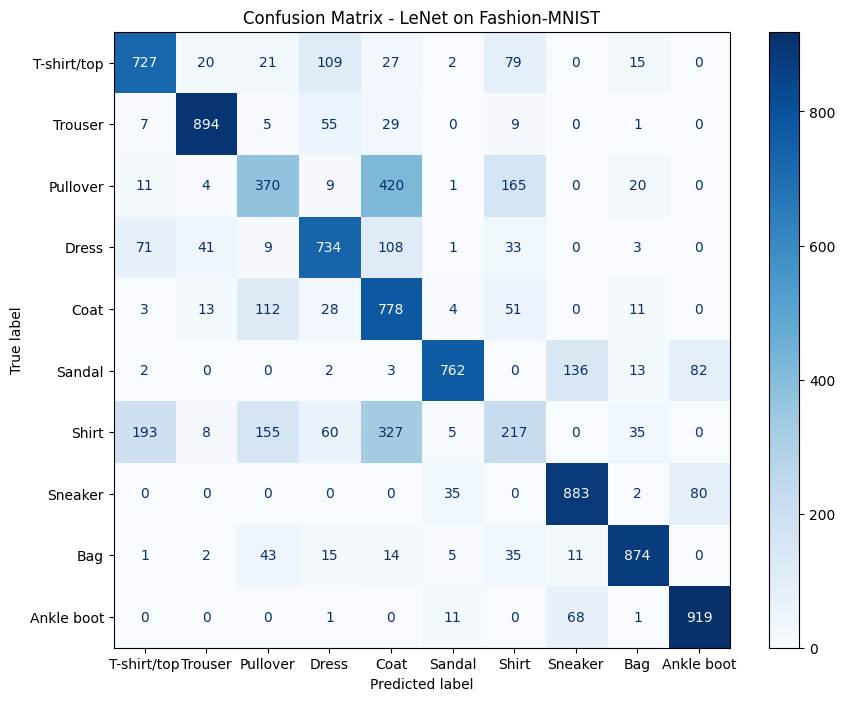

In [3]:
# --------------------------------
# Confusion Matrix Plot
# --------------------------------
from sklearn.metrics import ConfusionMatrixDisplay

# Get predicted and true labels
y_true = np.argmax(y_test_onehot, axis=1)
y_pred = np.argmax(test_preds, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
])
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix - LeNet on Fashion-MNIST")
plt.show()
